In [1]:
#Import necessary libraries
import numpy as np
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import gensim
from gensim.models import Word2Vec
from os import path
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report

# Data Exploration

Reading the training data from csv file

In [3]:
train_data_raw = pd.read_csv("/home/aravind/Desktop/Tasks/train1.csv")
train_data_raw.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


statistics of training data

Number of training data: 359999
Ratio of duplicate question pairs: 37.150000 %
Total number of question pairs: 359999
Number of question pairs appearing multiple times: 0


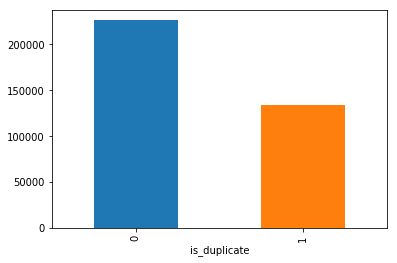

In [4]:
print "Number of training data: %d" %len(train_data_raw)
print "Ratio of duplicate question pairs: %f %%" %round(train_data_raw['is_duplicate'].mean()*100,2)
tids = pd.Series(train_data_raw['id'].tolist())
print "Total number of question pairs: %d" %len(np.unique(tids))
print "Number of question pairs appearing multiple times: %d" %np.sum(tids.value_counts()>1)
fig1=plt.figure()
train_data_raw.groupby("is_duplicate")['id'].count().plot.bar()
fig1.savefig('train_stat1.jpg',dpi=100)

Reading the test data from csv file

In [6]:
test_data_raw = pd.read_csv("/home/aravind/Desktop/Tasks/test1.csv")
test_data_raw=test_data_raw[np.isfinite(test_data_raw['label'])] #removing Nan labels

In [7]:
test_data_raw.head(5)

,id,idq1,idq2,question1,question2,label
0,359999,489723,342189,Where do steroid hormones have hormone recepto...,Is insulin a steroid hormone?,0
1,360000,489724,436643,What does the typical French house look like?,What does the typical Finnish house look like?,0
2,360001,489725,489726,How can I do my first pullup?,What would be the benefits / pitfalls if all t...,0
3,360002,176794,489727,Why do mainland Chinese people who make racial...,"How do people think about the HongKongers, who...",0
4,360003,489728,489729,Why does it seem that there are a lot of liber...,Would you be surprised to learn that it is lib...,0


Statistics of the Test data file

Number of testing data: 44291
Ratio of duplicate question pairs: 35.030000 %
Total number of question pairs: 44291
Number of question pairs appearing multiple times: 0


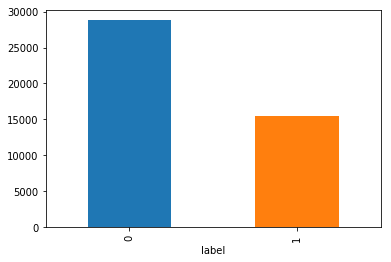

In [8]:
print "Number of testing data: %d" %len(test_data_raw)
print "Ratio of duplicate question pairs: %f %%" %round(test_data_raw['label'].mean()*100,2)
tids = pd.Series(test_data_raw['id'].tolist())
print "Total number of question pairs: %d" %len(np.unique(tids))
print "Number of question pairs appearing multiple times: %d" %np.sum(tids.value_counts()>1)
fig2=plt.figure()
test_data_raw.groupby("label")['id'].count().plot.bar()
fig2.savefig('test_stat1.jpg',dpi=100)

# Visualising the Most Common Words in Training Data

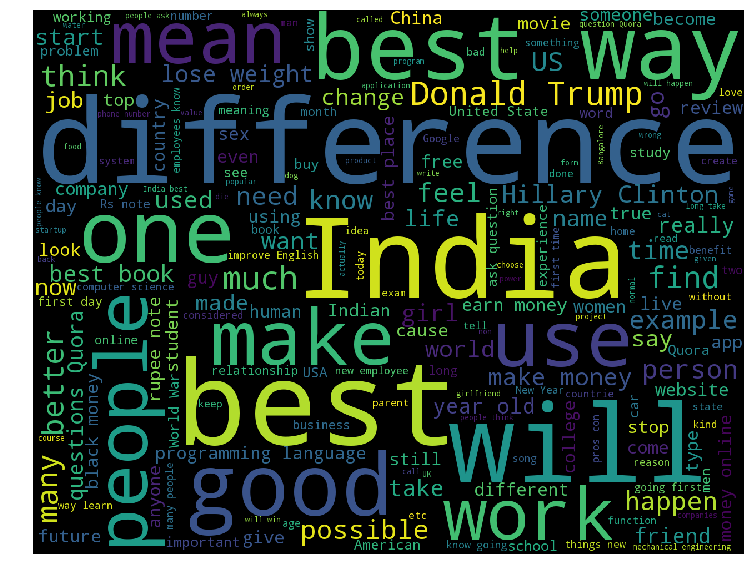

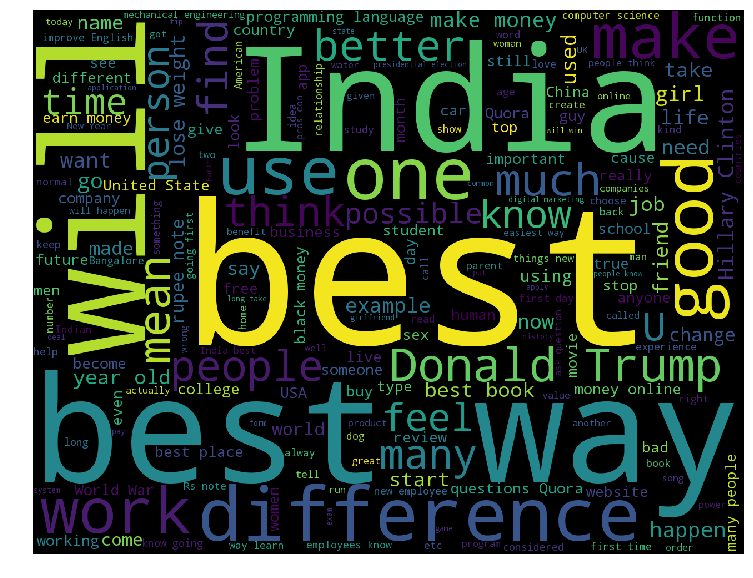

In [9]:
cloud1 = WordCloud(width=1280, height=980).generate(" ".join(train_data_raw['question1'].astype(str)))
cloud2 = WordCloud(width=1280, height=980).generate(" ".join(train_data_raw['question2'].astype(str)))
fig3=plt.figure(figsize=(15, 10))
plt.imshow(cloud1)
plt.axis('off')
fig4=plt.figure(figsize=(15, 10))
plt.imshow(cloud2)
plt.axis('off')
fig3.savefig('wordcloudtrain1.jpg',dpi=100)
fig4.savefig('wordcloudtrain2.jpg',dpi=100)

# Data Processing

Function to calculate normalized word share feature between two questions

In [10]:
def word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

Combine all the questions into corpus for TFIDF analysis

In [11]:
train_questions = pd.Series(train_data_raw['question1'].tolist() + train_data_raw['question2'].tolist()).astype(str)
test_questions = pd.Series(test_data_raw['question1'].tolist() + test_data_raw['question2'].tolist()).astype(str)
#Implement TFIDF function
def get_weight(count, eps=5000, min_count=2):
    if count < min_count:
        return 0 #remove words only appearing once 
    else:
        R = 1.0 / (count + eps)
        return R

eps = 5000 
words = (" ".join(train_questions)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}
print "Most common words: ", (sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])

Most common words:  [('the', 2.9434533183020982e-06), ('what', 3.5494725483793107e-06), ('is', 4.093998198640793e-06), ('how', 4.9999750001249995e-06), ('i', 5.135210081444432e-06), ('a', 5.207058688758481e-06), ('to', 5.366102331571463e-06), ('in', 5.610129650096214e-06), ('of', 6.823563128194281e-06), ('do', 7.010508752620178e-06)]


Function to calculate normalized tfidf share feature between two questions

In [12]:
def tfidf_word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" "))) 
    if len(w1)==0 or len(w2)==0:
        return 0
    common = w1 & w2
    share_weight = [weights.get(word, 0) for word in common]
    total_weight = [weights.get(word, 0) for word in w1]+[weights.get(word, 0) for word in w2]
    return np.sum(share_weight)/np.sum(total_weight)

Construct features for training data: character length, number of words, normalized word share 

In [13]:
train_data = pd.DataFrame(dtype='float64')
train_data['t1chrlen'] = train_data_raw['question1'].str.len()
train_data['t2chrlen'] = train_data_raw['question2'].str.len()
train_data['t1_nword'] = train_data_raw['question1'].apply(lambda x: len(str(x).split(" ")))
train_data['t2_nword'] = train_data_raw['question2'].apply(lambda y: len(str(y).split(" ")))
train_data['word_share'] = train_data_raw.apply(word_share_norm, axis=1)
train_data['TFIDF_share'] = train_data_raw.apply(tfidf_word_share_norm, axis=1, raw=True)
train_data.head()

,t1chrlen,t2chrlen,t1_nword,t2_nword,word_share,TFIDF_share
0,66,57.0,14,12,0.434783,0.400262
1,51,88.0,8,13,0.200000,0.190485
2,73,59.0,14,10,0.166667,0.149954
3,50,65.0,11,9,0.000000,0.000000
4,76,39.0,13,7,0.100000,0.010916


In [14]:
#Check if there's NaN values in the data. If yes, replace them.
np.sum(np.isnan(train_data))
train_data.loc[:,'t2chrlen'] = np.nan_to_num(train_data.loc[:,'t2chrlen'])
np.sum(np.isnan(train_data))

t1chrlen       0
t2chrlen       0
t1_nword       0
t2_nword       0
word_share     0
TFIDF_share    0
dtype: int64

Process test data features

In [15]:
test_data = pd.DataFrame()
test_data['t1chrlen'] = test_data_raw['question1'].str.len()
test_data['t2chrlen'] = test_data_raw['question2'].str.len()
test_data['t1_nword'] = test_data_raw['question1'].apply(lambda x: len(str(x).split(" ")))
test_data['t2_nword'] = test_data_raw['question2'].apply(lambda y: len(str(y).split(" ")))
test_data['word_share'] = test_data_raw.apply(word_share_norm, axis=1)
test_data['TFIDF_share'] = test_data_raw.apply(tfidf_word_share_norm, axis=1, raw=True)
#Replace NaN if any
np.sum(np.isnan(test_data))
test_data.loc[:,['t1chrlen','t2chrlen']] = np.nan_to_num(test_data.loc[:,['t1chrlen','t2chrlen']])
np.sum(np.isnan(test_data))

t1chrlen       0
t2chrlen       0
t1_nword       0
t2_nword       0
word_share     0
TFIDF_share    0
dtype: int64

In [16]:
test_data.head(5)

,t1chrlen,t2chrlen,t1_nword,t2_nword,word_share,TFIDF_share
0,54.0,29.0,8,5,0.076923,0.127177
1,45.0,46.0,8,8,0.437500,0.385741
2,29.0,90.0,7,15,0.000000,0.000000
3,135.0,106.0,20,16,0.171429,0.109916
4,145.0,111.0,28,17,0.146341,0.093682


# Feature Visualization and Normalization

visualization on character count

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


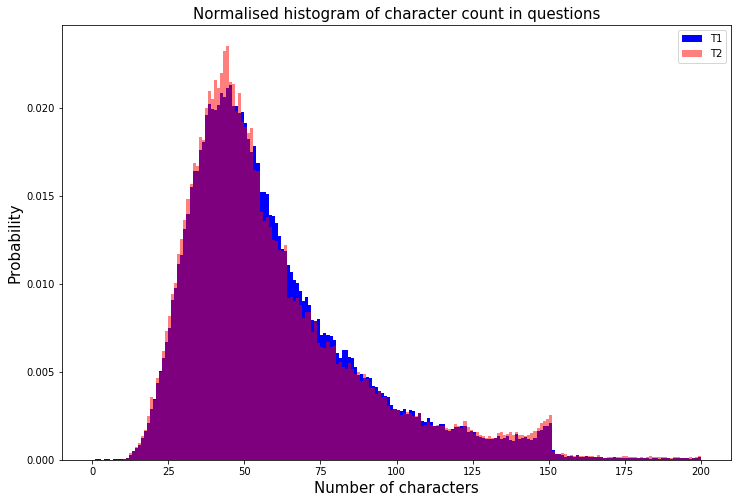

In [17]:
fig5=plt.figure(figsize=(12, 8))
plt.hist(train_data['t1chrlen'], bins=200, range=[0, 200], color='blue', normed=True, label='T1')
plt.hist(train_data['t2chrlen'], bins=200, range=[0, 200], color='red',alpha = 0.5, normed=True, label='T2')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)
fig5.savefig('vishistcc.jpeg',dpi=100)

Visualization on word count

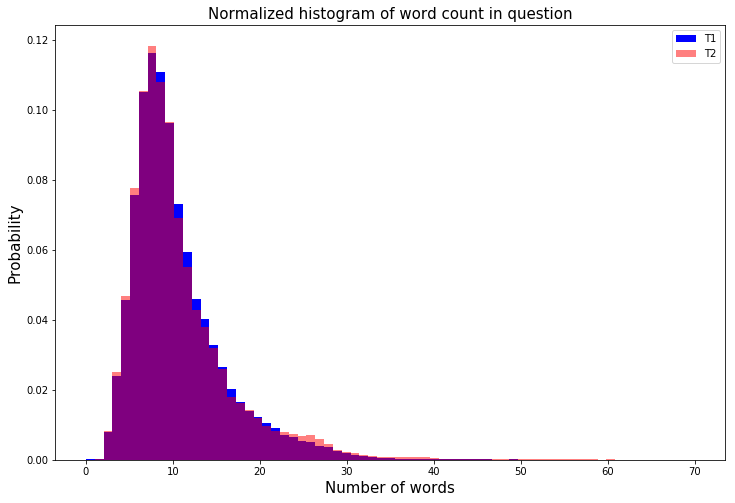

In [21]:
fig6=plt.figure(figsize=(12, 8))
plt.hist(train_data['t1_nword'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='blue', label='T1')
plt.hist(train_data['t2_nword'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='red',alpha = 0.5, label='T2')
plt.title('Normalized histogram of word count in question', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)
fig6.savefig('vishistwc.jpeg',dpi=100)

Visualization of words_share

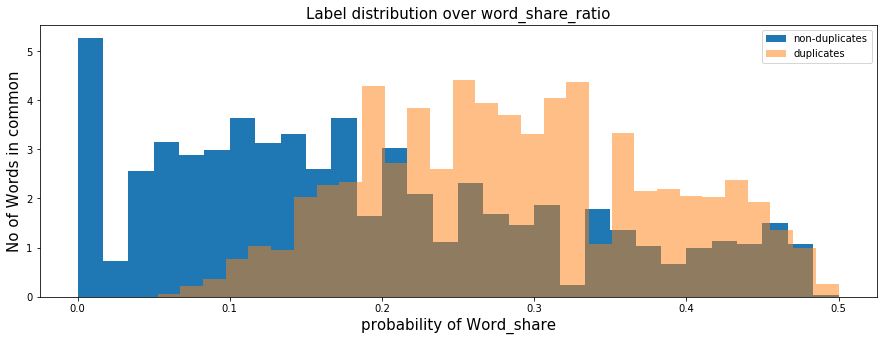

In [20]:
fig7=plt.figure(figsize=(15, 5))
train_word_share = train_data['word_share']
plt.hist(train_word_share[train_data_raw['is_duplicate'] == 0], bins=30, normed=True, label='non-duplicates')
plt.hist(train_word_share[train_data_raw['is_duplicate'] == 1], bins=30, normed=True, alpha=0.5, label='duplicates')
plt.legend()
plt.title('Label distribution over word_share_ratio', fontsize=15)
plt.xlabel('probability of Word_share', fontsize=15)
plt.ylabel('No of Words in common', fontsize=15)
fig7.savefig('vislabelws.jpeg',dpi=100)

Visualization on TFIDF word share

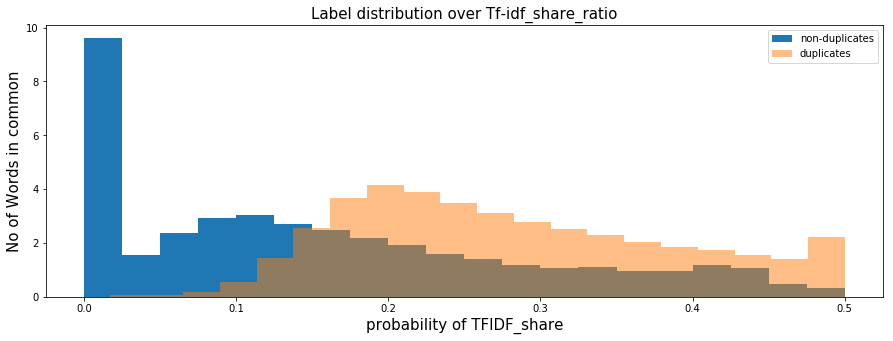

In [22]:
fig8=plt.figure(figsize=(15, 5))
train_tfidf = train_data['TFIDF_share'].fillna(0)
plt.hist(train_tfidf[train_data_raw['is_duplicate'] == 0], bins=20, normed=True, label='non-duplicates')
plt.hist(train_tfidf[train_data_raw['is_duplicate'] == 1], bins=20, normed=True, alpha=0.5, label='duplicates')
plt.legend()
plt.title('Label distribution over Tf-idf_share_ratio', fontsize=15)
plt.xlabel('probability of TFIDF_share', fontsize=15)
plt.ylabel('No of Words in common', fontsize=15)
fig8.savefig('vistfidf.jpeg',dpi=100)

Normalizing the feature values

In [23]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.fit_transform(test_data)

Split training data into train and Cross-validation data sets in 0.8 and 0.2 ratio

In [24]:
label = train_data_raw['is_duplicate']
label2=test_data_raw['label'] #label2 =test data labels
X_train, X_valid, y_train, y_valid = train_test_split(train_data, label, test_size=0.2, random_state=10)
X_train_scaled, X_valid_scaled, y_train, y_valid = train_test_split(train_data_scaled, label, test_size=0.2, random_state=10)

# ML Models

# Random Forest

Training model and Cross validation accuracy

In [25]:
#Benchmark model : random forest
rfc = RandomForestClassifier(max_depth=5, random_state=0)
rfc.fit(X_train_scaled,y_train)
prediction = rfc.predict_proba(X_valid_scaled)
pre = rfc.predict(X_valid_scaled)
score_rfc = rfc.score(X_valid_scaled, y_valid)
print "Random Forest (Benchmark model) has accuracy: %.3f" %score_rfc
print classification_report(y_valid, pre, target_names=['0','1'])

Random Forest (Benchmark model) has accuracy: 0.723
             precision    recall  f1-score   support

          0       0.85      0.68      0.76     45364
          1       0.59      0.80      0.68     26636

avg / total       0.75      0.72      0.73     72000



Testing the training model with Test data and Predicting the class

In [33]:
rfc = RandomForestClassifier(max_depth=5, random_state=0)
rfc.fit(train_data_scaled,label)
prediction = rfc.predict_proba(test_data_scaled)
pre = rfc.predict(test_data_scaled)
score_rfc = rfc.score(test_data_scaled, label2)
print "Random Forest (Benchmark model) has accuracy: %.3f" %score_rfc
print classification_report(label2, pre, target_names=['0','1'])

Random Forest (Benchmark model) has accuracy: 0.721
             precision    recall  f1-score   support

          0       0.86      0.68      0.76     28776
          1       0.57      0.80      0.67     15515

avg / total       0.76      0.72      0.73     44291



In [34]:
print "length of predicted label:",len(pre)

length of predicted label: 44291


In [28]:
print "prdicted Label:",pre
print "Test_label:",label2

prdicted Label: [0 1 0 ... 1 0 1]
Test_label: 0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        1
8        0
9        0
10       0
11       1
12       0
13       0
14       1
15       1
16       0
17       0
18       0
19       0
20       0
21       1
22       0
23       0
24       1
25       0
26       0
27       0
28       1
29       1
        ..
44261    0
44262    1
44263    0
44264    0
44265    0
44266    1
44267    0
44268    1
44269    0
44270    0
44271    0
44272    0
44273    1
44274    1
44275    1
44276    0
44277    0
44278    0
44279    0
44280    0
44281    1
44282    1
44283    1
44284    0
44285    1
44286    0
44287    1
44288    0
44289    0
44290    0
Name: label, Length: 44291, dtype: int64


# Logistic Regression

Training model and Cross validation accuracy

In [31]:
#Model 1: Logistic regression model
#Use GridSearch cross validation to find best parameter
lr = LogisticRegression(random_state=10)
grid = {
    'C': [1e-6, 1e-3, 1e0, 1e3, 1e6],
    'penalty': ['l1', 'l2']
}
cv = GridSearchCV(lr, grid, scoring='neg_log_loss', verbose = True)
cv.fit(X_train_scaled, y_train)
print cv.best_params_
pre=cv.predict(X_valid_scaled)
score_lr = cv.best_estimator_.score(X_valid_scaled, y_valid)
print "Logistic regression model accuracy: %.3f" %score_lr
print classification_report(y_valid, pre, target_names=['0','1'])


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   27.3s finished


{'penalty': 'l2', 'C': 1.0}
Logistic regression model accuracy: 0.668
             precision    recall  f1-score   support

          0       0.71      0.79      0.75     45364
          1       0.56      0.45      0.50     26636

avg / total       0.66      0.67      0.66     72000



Testing the training model with Test data and Predicting the class

In [35]:
#Model 1: Logistic regression model
#Use GridSearch cross validation to find best parameter
lr = LogisticRegression(random_state=10)
grid = {
    'C': [1e-6, 1e-3, 1e0, 1e3, 1e6],
    'penalty': ['l1', 'l2']
}
cv = GridSearchCV(lr, grid, scoring='neg_log_loss', verbose = True)
cv.fit(train_data_scaled,label)
print cv.best_params_
pre=cv.predict(test_data_scaled)
score_lr = cv.best_estimator_.score(test_data_scaled,label2)
print "Logistic regression model accuracy: %.3f" %score_lr
print classification_report(label2, pre, target_names=['0','1'])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   35.3s finished


{'penalty': 'l1', 'C': 1.0}
Logistic regression model accuracy: 0.674
             precision    recall  f1-score   support

          0       0.73      0.79      0.76     28776
          1       0.54      0.46      0.50     15515

avg / total       0.66      0.67      0.67     44291



In [36]:
print "length of predicted label:",len(pre)

length of predicted label: 44291


In [37]:
print "prdicted Label:",pre
print "Test_label:",label2

prdicted Label: [0 1 0 ... 1 0 1]
Test_label: 0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        1
8        0
9        0
10       0
11       1
12       0
13       0
14       1
15       1
16       0
17       0
18       0
19       0
20       0
21       1
22       0
23       0
24       1
25       0
26       0
27       0
28       1
29       1
        ..
44261    0
44262    1
44263    0
44264    0
44265    0
44266    1
44267    0
44268    1
44269    0
44270    0
44271    0
44272    0
44273    1
44274    1
44275    1
44276    0
44277    0
44278    0
44279    0
44280    0
44281    1
44282    1
44283    1
44284    0
44285    1
44286    0
44287    1
44288    0
44289    0
44290    0
Name: label, Length: 44291, dtype: int64


# Decision Tree

Training model and Cross validation accuracy

In [38]:
#Model 2: Decision tree 
dt = DecisionTreeClassifier(max_depth = 100, random_state=10)
dt.fit(X_train_scaled, y_train)
prediction = dt.predict(X_valid_scaled)
score_dt = dt.score(X_valid_scaled, y_valid)
print "Decision tree model accuracy: %.3f" %score_dt
print classification_report(y_valid, prediction, target_names=['0','1'])

Decision tree model accuracy: 0.696
             precision    recall  f1-score   support

          0       0.76      0.76      0.76     45364
          1       0.59      0.59      0.59     26636

avg / total       0.70      0.70      0.70     72000



Testing the training model with Test data and Predicting the class

In [39]:
#Model 2: Decision tree 
dt = DecisionTreeClassifier(max_depth = 100, random_state=10)
dt.fit(train_data_scaled,label)
prediction = dt.predict(test_data_scaled)
score_dt = dt.score(test_data_scaled,label2)
print "Decision tree model accuracy: %.3f" %score_dt
print classification_report(label2, prediction, target_names=['0','1'])

Decision tree model accuracy: 0.691
             precision    recall  f1-score   support

          0       0.77      0.75      0.76     28776
          1       0.56      0.58      0.57     15515

avg / total       0.69      0.69      0.69     44291



In [40]:
print "prdicted Label:",pre
print "Test_label:",label2

prdicted Label: [0 1 0 ... 1 0 1]
Test_label: 0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        1
8        0
9        0
10       0
11       1
12       0
13       0
14       1
15       1
16       0
17       0
18       0
19       0
20       0
21       1
22       0
23       0
24       1
25       0
26       0
27       0
28       1
29       1
        ..
44261    0
44262    1
44263    0
44264    0
44265    0
44266    1
44267    0
44268    1
44269    0
44270    0
44271    0
44272    0
44273    1
44274    1
44275    1
44276    0
44277    0
44278    0
44279    0
44280    0
44281    1
44282    1
44283    1
44284    0
44285    1
44286    0
44287    1
44288    0
44289    0
44290    0
Name: label, Length: 44291, dtype: int64


# SVM

Training model and Cross validation accuracy

In [46]:
#Model 3: SVM model
#Use GridSearch cross validation to find best parameter
svm = SVC(random_state=0, max_iter=500, probability=True)
grid = {
    'C': [1e-3, 1e0, 1e3],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
cv = GridSearchCV(svm, grid, scoring='neg_log_loss', verbose = True)
cv.fit(X_train_scaled, y_train)
print cv.best_params_
score_svm = cv.best_estimator_.score(X_valid_scaled, y_valid)
pre=cv.predict(X_valid_scaled)
print "SVM model accuracy: %.3f" %score_svm
print classification_report(y_valid, pre, target_names=['0','1'])

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python2.7/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 50.6min finished


{'kernel': 'sigmoid', 'C': 0.001}
SVM model accuracy: 0.599
             precision    recall  f1-score   support

          0       0.78      0.51      0.61     45364
          1       0.47      0.76      0.58     26636

avg / total       0.67      0.60      0.60     72000



Testing the training model with Test data and Predicting the class

In [36]:
svm = SVC(random_state=0, max_iter=500, probability=True)
grid = {
    'C': [1e-3, 1e0, 1e3],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
cv = GridSearchCV(svm, grid, scoring='neg_log_loss', verbose = True)
cv.fit(train_data_scaled,label)
print cv.best_params_
score_svm = cv.best_estimator_.score(test_data_scaled,label2)
pre=cv.predict(test_data_scaled)
print "SVM model accuracy: %.3f" %score_svm
print classification_report(label2, pre, target_names=['0','1'])

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 54.7min finished


{'kernel': 'sigmoid', 'C': 0.001}
SVM model accuracy: 0.610
             precision    recall  f1-score   support

          0       0.79      0.54      0.64     28776
          1       0.46      0.74      0.57     15515

avg / total       0.68      0.61      0.62     44291



In [28]:
print "prdicted Label:",pre
print "Test_label:",label2

prdicted Label: [0 1 0 ... 1 0 1]
Test_label: 0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        1
8        0
9        0
10       0
11       1
12       0
13       0
14       1
15       1
16       0
17       0
18       0
19       0
20       0
21       1
22       0
23       0
24       1
25       0
26       0
27       0
28       1
29       1
        ..
44261    0
44262    1
44263    0
44264    0
44265    0
44266    1
44267    0
44268    1
44269    0
44270    0
44271    0
44272    0
44273    1
44274    1
44275    1
44276    0
44277    0
44278    0
44279    0
44280    0
44281    1
44282    1
44283    1
44284    0
44285    1
44286    0
44287    1
44288    0
44289    0
44290    0
Name: label, Length: 44291, dtype: int64


# KNN

Training model and Cross validation accuracy

In [44]:
knn = KNeighborsClassifier()
grid = {
    'n_neighbors': list(range(2, 10, 2)),
    'weights': ['uniform', 'distance']
}
cv = GridSearchCV(knn, grid, scoring='neg_log_loss', verbose = True)
cv.fit(X_train_scaled, y_train)
print cv.best_params_
score_knn = cv.best_estimator_.score(X_valid_scaled, y_valid)
pre=cv.predict(X_valid_scaled)
print "K Nearest Neighbor model accuracy: %.3f" %score_knn
print classification_report(y_valid, pre, target_names=['0','1'])


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  6.9min finished


{'n_neighbors': 8, 'weights': 'uniform'}
K Nearest Neighbor model accuracy: 0.721
             precision    recall  f1-score   support

          0       0.76      0.81      0.78     45364
          1       0.64      0.57      0.60     26636

avg / total       0.72      0.72      0.72     72000



Testing the training model with Test data and Predicting the class

In [45]:
knn = KNeighborsClassifier()
grid = {
    'n_neighbors': list(range(2, 10, 2)),
    'weights': ['uniform', 'distance']
}
cv = GridSearchCV(knn, grid, scoring='neg_log_loss', verbose = True)
cv.fit(train_data_scaled,label)
print cv.best_params_
score_knn = cv.best_estimator_.score(test_data_scaled,label2)
pre=cv.predict(test_data_scaled)
print "K Nearest Neighbor model accuracy: %.3f" %score_knn
print classification_report(label2, pre, target_names=['0','1'])

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  9.7min finished


{'n_neighbors': 8, 'weights': 'uniform'}
K Nearest Neighbor model accuracy: 0.720
             precision    recall  f1-score   support

          0       0.78      0.80      0.79     28776
          1       0.61      0.57      0.59     15515

avg / total       0.72      0.72      0.72     44291



In [28]:
print "prdicted Label:",pre
print "Test_label:",label2

prdicted Label: [0 1 0 ... 1 0 1]
Test_label: 0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        1
8        0
9        0
10       0
11       1
12       0
13       0
14       1
15       1
16       0
17       0
18       0
19       0
20       0
21       1
22       0
23       0
24       1
25       0
26       0
27       0
28       1
29       1
        ..
44261    0
44262    1
44263    0
44264    0
44265    0
44266    1
44267    0
44268    1
44269    0
44270    0
44271    0
44272    0
44273    1
44274    1
44275    1
44276    0
44277    0
44278    0
44279    0
44280    0
44281    1
44282    1
44283    1
44284    0
44285    1
44286    0
44287    1
44288    0
44289    0
44290    0
Name: label, Length: 44291, dtype: int64


# Multinomial NB

Training model and Cross validation accuracy

In [41]:
mnb = MultinomialNB().fit(X_train, y_train)
score_nb = mnb.score(X_valid,y_valid)
pre=mnb.predict(X_valid_scaled)
print "Naive Bayes model accuracy: %.3f" %score_nb
print classification_report(y_valid, pre, target_names=['0','1'])

Naive Bayes model accuracy: 0.628
             precision    recall  f1-score   support

          0       0.73      0.77      0.75     45364
          1       0.57      0.53      0.55     26636

avg / total       0.67      0.68      0.68     72000



Testing the training model with Test data and Predicting the class

In [42]:
mnb = MultinomialNB().fit(train_data,label)
score_nb = mnb.score(test_data,label2)
pre=mnb.predict(test_data)
print "Naive Bayes model accuracy: %.3f" %score_nb
print classification_report(label2, pre, target_names=['0','1'])

Naive Bayes model accuracy: 0.647
             precision    recall  f1-score   support

          0       0.65      0.99      0.78     28776
          1       0.40      0.01      0.03     15515

avg / total       0.56      0.65      0.52     44291



In [43]:
print "prdicted Label:",pre
print "Test_label:",label2

prdicted Label: [0 0 0 ... 0 0 0]
Test_label: 0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        1
8        0
9        0
10       0
11       1
12       0
13       0
14       1
15       1
16       0
17       0
18       0
19       0
20       0
21       1
22       0
23       0
24       1
25       0
26       0
27       0
28       1
29       1
        ..
44261    0
44262    1
44263    0
44264    0
44265    0
44266    1
44267    0
44268    1
44269    0
44270    0
44271    0
44272    0
44273    1
44274    1
44275    1
44276    0
44277    0
44278    0
44279    0
44280    0
44281    1
44282    1
44283    1
44284    0
44285    1
44286    0
44287    1
44288    0
44289    0
44290    0
Name: label, Length: 44291, dtype: int64
